# Multi-Factor Trend Quality Assessment & Dynamic Ranking Trading System for Futures
This project develops a daily-frequency trend trading system for futures, employing multi-dimensional trend analysis and a dynamic ranking mechanism. The framework integrates five core indicators—momentum returns, ADX trend strength, volatility-adjusted returns, linear regression R², and its median-filtered value—to comprehensively evaluate both trend strength and smoothness.
Through adaptive weight optimization via grid search, the system identifies the optimal parameter set (w1=0.25, w2=0.00, w3=0.75), revealing that trend smoothness contributes significantly more to returns than trend strength.
**GitHub Repository:** https://github.com/Joanna-git/RA_24

In [ ]:
# Required Libraries
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.display import display
# Strategy Parameters
start_date = '2010-01-01'
end_date = '2025-05-20'
holding_days = 1  # Daily portfolio rebalancing

In [ ]:
data_folder = './' 
# Automated Symbol List Construction
symbols = [f.replace("Alternative_price_", "").replace(".csv", "") 
           for f in os.listdir(data_folder) 
           if f.startswith("Alternative_price_R_CN") and f.endswith(".csv")]
# Load All CSV Files as DataFrame
def load_all_local_prices(symbols, folder):
    data_dict = {}
    for sym in symbols:
        filename = f"Alternative_price_{sym}.csv"
        filepath = os.path.join(folder, filename)
        df = pd.read_csv(filepath)
        df.columns = [col.strip().upper() for col in df.columns]  # Standardize column names
        df['CLOCK'] = pd.to_datetime(df['CLOCK'])
        df.set_index('CLOCK', inplace=True)
        df = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']]
        data_dict[sym] = df
    return data_dict
Alternative_price_data = load_all_local_prices(symbols, data_folder)


In [ ]:
# Trend Factor Calculation
def Alternative_calc_trend_factors(price_df, window=14, norm_window=60):
    price, dates = price_df['CLOSE'].values, price_df.index
    momentum = (price[window:] - price[:-window]) / price[:-window]      # Momentum: simple return over window period (directional magnitude)
    returns = pd.Series(price).pct_change().fillna(0)
    vol_adj_ret = returns.rolling(window).mean() / (returns.rolling(window).std() + 1e-8)    # Volatility-adjusted returns: mean return divided by standard deviation (risk-reward ratio)
    vol_adj_ret = vol_adj_ret[window:]
    high, low, close = price_df['HIGH'], price_df['LOW'], price_df['CLOSE']        # ADX (Average Directional Index) : Measures trend strength using True Range, Directional Movement
    prev_close, prev_high, prev_low = close.shift(1), high.shift(1), low.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)    # True Range calculation
    plus_dm = (high - prev_high).where((high - prev_high > 0) & ((high - prev_high) > (prev_low - low)), 0)
    minus_dm = (prev_low - low).where((prev_low - low > 0) & ((prev_low - low) > (high - prev_high)), 0)
    tr14, plus_di14 = tr.rolling(window).mean(), 100 * plus_dm.rolling(window).mean() / (tr14 + 1e-8)
    minus_di14, dx = 100 * minus_dm.rolling(window).mean() / (tr14 + 1e-8), 100 * (plus_di14 - minus_di14).abs() / ((plus_di14 + minus_di14) + 1e-8)
    adx = dx.rolling(window).mean()[window:]
    alpha, beta, gamma, trend_dir = 0.4, 0.4, 0.2, np.sign(momentum)
    trend_strength_raw = alpha * np.abs(momentum) + beta * np.nan_to_num(adx.values) + gamma * np.abs(np.nan_to_num(vol_adj_ret.values))
    ts = trend_dir * trend_strength_raw
    strength, consistency = [], []
    for i in range(window, len(price_df)):
        sub_y, x = price[i - window:i], np.arange(window).reshape(-1, 1)
        model, pred = LinearRegression().fit(x, sub_y), model.predict(x)
        mse, var = np.mean((sub_y - pred)**2), np.var(sub_y)
        tc = 1 - mse / var if var > 1e-6 else 0
        strength.append(ts[i - window])
        consistency.append(tc)
    # Trend Smoothness (TC - R-squared from linear regression)
    strength_series, consistency_series = pd.Series(strength, index=dates[window:]), pd.Series(consistency, index=dates[window:])
    strength_norm = (strength_series - strength_series.rolling(norm_window, min_periods=10).mean()) / (strength_series.rolling(norm_window, min_periods=10).std() + 1e-8)
    consistency_norm = (consistency_series - consistency_series.rolling(norm_window, min_periods=10).mean()) / (consistency_series.rolling(norm_window, min_periods=10).std() + 1e-8)
    rtc = consistency_series.rolling(window=5, center=True, min_periods=1).median()
    signed_consistency_norm, signed_rtc = np.sign(strength_norm) * consistency_norm, np.sign(strength_norm) * rtc
    df = pd.DataFrame({'trend_strength': strength_series, 'trend_consistency': consistency_series, 'trend_strength_norm': strength_norm, 'trend_consistency_norm': consistency_norm, 'RTC': rtc})
    df['composite_score'] = 0.5 * strength_norm + 0.25 * signed_consistency_norm + 0.25 * signed_rtc
    df['symbol'] = price_df.columns[-1] if 'symbol' not in price_df.columns else price_df['symbol'].iloc[0]
    df.index.name = 'date'
    return df

- Code for multi-asset scoring matrix, fee mapping, and backtest metrics omitted

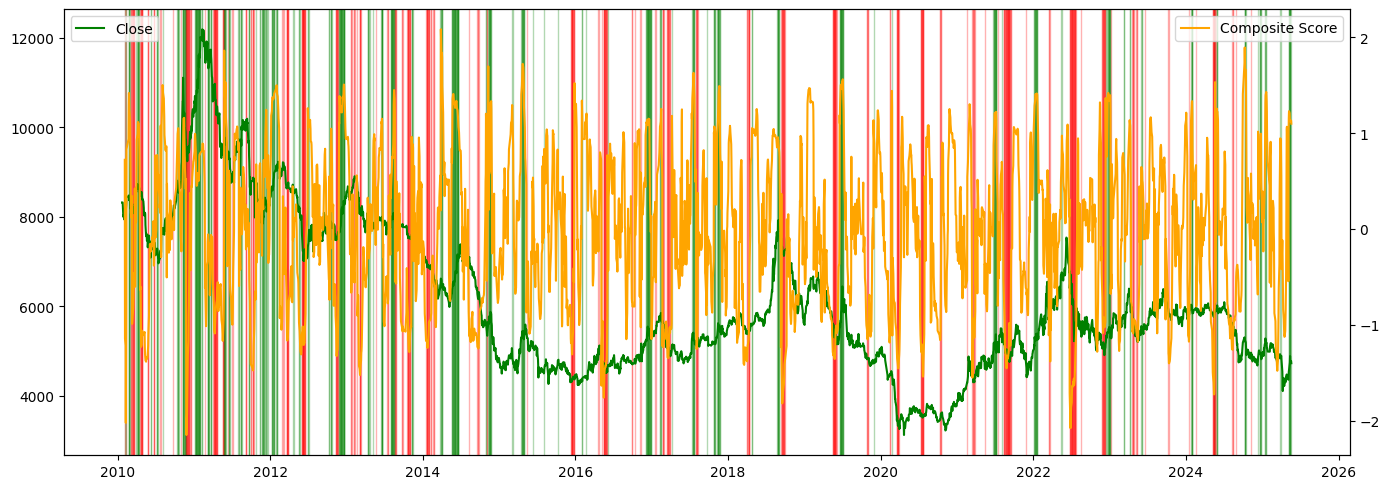

In [ ]:
# Signal Testing and Visualization
def mark_long_short_signal(score_df, symbol, top_n=5, bottom_n=5):
    df = score_df[score_df['symbol'] == symbol].copy()
    score_pivot = score_df.reset_index().pivot(index='date', columns='symbol', values='composite_score')
    df['long_signal'] = score_pivot.rank(axis=1, ascending=False)[symbol] <= top_n
    df['short_signal'] = score_pivot.rank(axis=1, ascending=True)[symbol] <= bottom_n
    return df
def plot_signal_simulation(score_df, price_data, symbol, top_n=5, bottom_n=5):
    df_score = score_df[score_df['symbol'] == symbol].copy().reset_index()
    df_price = price_data[symbol].copy()
    df_score['date'] = pd.to_datetime(df_score['date'])
    df = pd.merge(df_score, df_price, left_on='date', right_index=True, how='inner')
    df.set_index('date', inplace=True)
    signal_df = mark_long_short_signal(score_df, symbol, top_n, bottom_n)
    df['long_signal'] = signal_df.reset_index().set_index('date').reindex(df.index)['long_signal']
    df['short_signal'] = signal_df.reset_index().set_index('date').reindex(df.index)['short_signal']
    fig, ax1 = plt.subplots(figsize=(14, 5))
    ax1.plot(df.index, df['CLOSE'], label='Close', color='green')
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['composite_score'], label='Composite Score', color='orange')
    for i in range(len(df)):
        if df['long_signal'].iloc[i]:
            ax1.axvspan(df.index[i], df.index[i], color='green', alpha=0.3)
        elif df['short_signal'].iloc[i]:
            ax1.axvspan(df.index[i], df.index[i], color='red', alpha=0.3)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
plot_signal_simulation(Alternative_score_data, Alternative_price_data, 'R_CN_CZC_TA_0004', top_n=3, bottom_n=3)


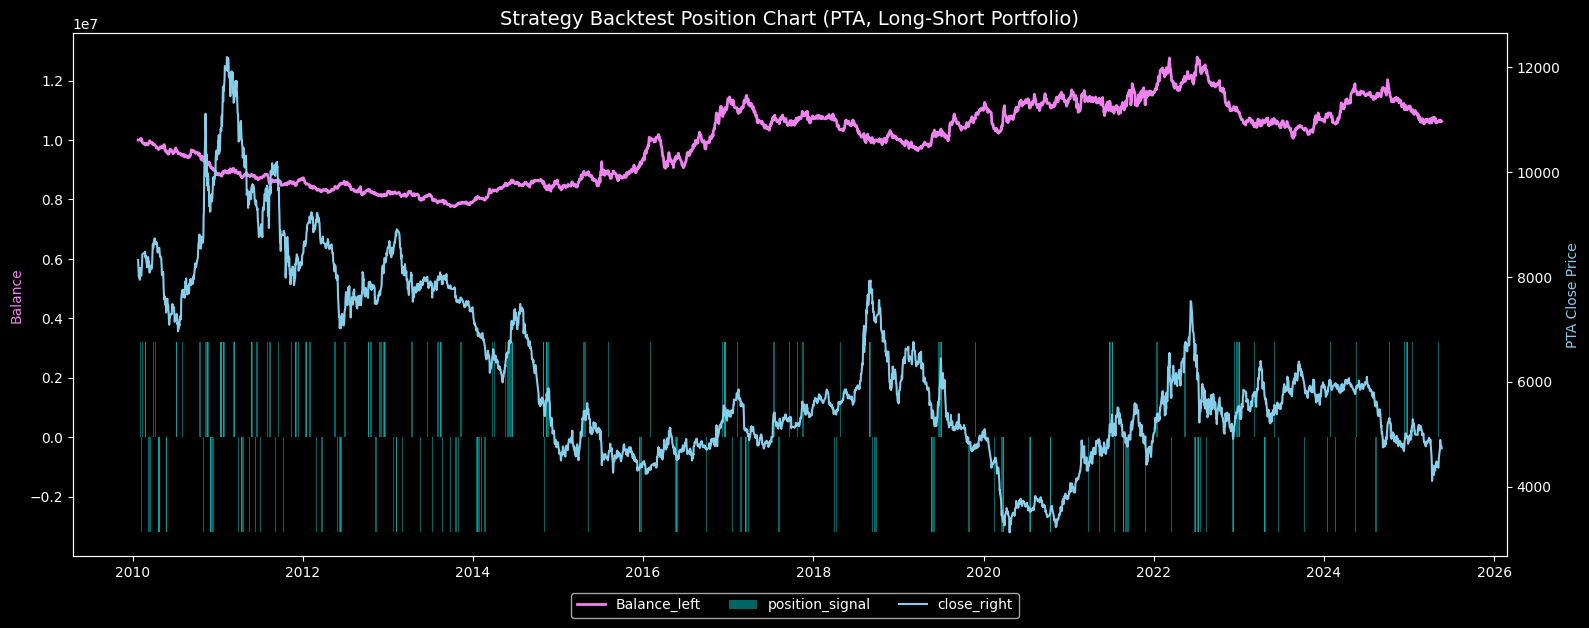

In [ ]:
# Strategy Position Visualization (Green bars upward = Long, signal 1; Green bars downward = Short, signal -1)
pta_price = Alternative_price_data['R_CN_CZC_TA_0004']['CLOSE']
pta_position = extract_pta_position_signal(Alternative_score_data, top_n=3)
pta_balance = pnl_df['balance']
pta_price = pta_price[pta_price.index.isin(pta_balance.index)]
pta_position = pta_position[pta_position.index.isin(pta_balance.index)]
plot_strategy_position(pta_balance, pta_price, pta_position)


In [ ]:
# Parameter Sensitivity Analysis and 3D-Weight Visualization
from mpl_toolkits.mplot3d import Axes3D
def composite_score_with_weights(df, w1, w2, w3):
    df = df.copy()
    sign_strength = np.sign(df['trend_strength_norm'])
    df['composite_score'] = w1 * df['trend_strength_norm'] + w2 * sign_strength * df['trend_consistency_norm'] + w3 * sign_strength * df['RTC']
    return df
def parameter_sensitivity_analysis_weights_3d(price_data, multiplier_df, w_steps=5, window=40, norm_window=50, init_cap=1e7, top_n=3):
    results = []
    weights = np.linspace(0, 1, w_steps)
    for w1 in weights:
        for w2 in weights:
            w3 = 1 - w1 - w2
            if w3 < 0: continue
            all_scores = []
            for sym, df_price in price_data.items():
                try:
                    score_df = Alternative_calc_trend_factors(df_price, window=window, norm_window=norm_window)
                    score_df['symbol'] = sym
                    all_scores.append(composite_score_with_weights(score_df, w1, w2, w3))
                except Exception as e:
                    print(f"Skipping {sym}: {e}")
                    continue
            if all_scores:
                total_score_df = pd.concat(all_scores)
                pnl_df = run_long_short_backtest(total_score_df, price_data, multiplier_df, top_n=top_n, init_cap=init_cap)
                sharpe = calculate_sharpe(pnl_df['balance'])
                results.append({'w1': w1, 'w2': w2, 'w3': w3, 'sharpe': sharpe})
                print(f"Weights ({w1:.2f},{w2:.2f},{w3:.2f}) Sharpe: {sharpe:.3f}")
    return pd.DataFrame(results)
# Execute sensitivity analysis
result_weights_df = parameter_sensitivity_analysis_weights_3d(
    Alternative_price_data, multiplier_df, w_steps=5, window=10, norm_window=60, init_cap=1e7, top_n=3
)
# 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(result_weights_df['w1'], result_weights_df['w2'], result_weights_df['w3'],
                c=result_weights_df['sharpe'], cmap='viridis', s=50)
ax.set_xlabel('Weight w1 (Strength)'); ax.set_ylabel('Weight w2 (Consistency)'); ax.set_zlabel('Weight w3 (RTC)')
ax.set_title('Composite Score Weights Sensitivity: Sharpe Ratio')
plt.colorbar(sc, label='Sharpe Ratio')
plt.show()

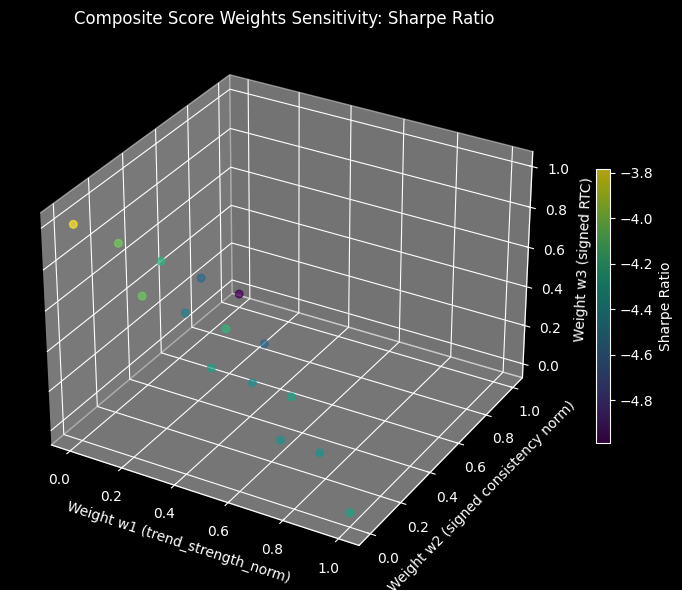

In [27]:
result_weights_df = pd.read_csv('parameter_sensitivity_results.csv')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(result_weights_df['w1'], result_weights_df['w2'], result_weights_df['w3'],c=result_weights_df['sharpe'], 
                cmap='viridis', s=30,alpha=0.7)
ax.set_xlabel('Weight w1 (trend_strength_norm)')
ax.set_ylabel('Weight w2 (signed consistency norm)')
ax.set_zlabel('Weight w3 (signed RTC)')
ax.set_title('Composite Score Weights Sensitivity: Sharpe Ratio')
cbar = fig.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Sharpe Ratio')
plt.tight_layout()
plt.show()